# Paso 1: Preparación de templates

Este código tieno como objetivo preparar las formas de onda que se ocuparan como templates para escanear los datos sísmicos continuos en busqueda de microsismicidad. El código abrirá el archivo de datos continuos que fue preparado en el Paso 0. En seguida, el código leerá de dos archivos (cátalogos) los eventos sísmicos que se usarán como templates (catalogo_tutorial.txt) y la información de los arribos de onda P y S (info_evento.txt). Con base en los datos de los eventos y en la información de los arrivos P y S para cada evento, el código construirá los templates cortando las correspondientes formas de onda para cada estación y componente. Finalmente, el código guardará la información de los templates: tiempos de arrivo, desface entre formas de onda, nombre de las estaciones, fecha de los eventos usados como templates.

In [1]:
# Importamos los paquetes que se van a utilizar
import datetime, matplotlib, glob
import h5py as h5
import numpy as np
from datetime import datetime
from datetime import timedelta
from obspy.core import UTCDateTime as udt
from matplotlib.dates import DayLocator, HourLocator, DateFormatter, drange
import utils
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
from collections import defaultdict
import konno_ohmachi as ko
import obspy as obs

# Definición de algunas subfunciones útiles

In [2]:
# Definimos algunas funciones útiles para el análisis de señales

# next_power_of_2: Estima la potencia en base 2 (hacia arriba) más próxima a un número dado
# por ejemplo: next_power_of_2(5) = 8
# la potencia en base 2 más próxima a 5 es 2^3 = 8
def next_power_of_2(x):
    return 1 if x == 0 else 2**(x - 1).bit_length()

# list_duplicates: devuelve una lista con los elementos que se duplican en una lista de entrada
def list_duplicates(seq):
    tally = defaultdict(list)
    for i,item in enumerate(seq):
        tally[item].append(i)
    return ((key,locs) for key,locs in tally.items()
                            if len(locs)>1)
# list_no_duplicates: devuelve una lista con los elementos que no se duplican en una lista de entrada
def list_no_duplicates(seq):
    tally = defaultdict(list)
    for i,item in enumerate(seq):
        tally[item].append(i)
    return ((key,locs) for key,locs in tally.items()
                           if len(locs)>0)


In [3]:
# Definimos la carpeta donde los datos continuos están guardados
#path_to_data = '/home/insar/Bureau/datos/preparados/'
path_to_data = '/home/sanchezh/datos/preparados/'

# Definimos la carpeta donde vamos a guardar el archivo de salida con los templates
#path_template = '/home/insar/Bureau/datos/templates/'
path_template = '/home/sanchezh/datos/templates/'

In [4]:
# Graficación de estación, id de la estación a graficar
station_plot = 0

# Definición del tamaño de letra deseado en las figuras por graficar
font = {'family': 'serif',
        'size': 12}
plt.rc('font', **font)


In [5]:
# Definimos las estaciones para las cuales queremos preparar templates
stations = ['LAGN']
# Tasa del muestreo en los datos sísmicos, BHZ, BHN, BHE = 50 Hz = 0.02 muestras por segundo
sampling_rate = 0.02
# Tasa de muestreo en el dominio de las frecuencias
sampling_freq = 1. / sampling_rate

# Leemos el catálogo de eventos a utilizar para crear los templates
with open('catalogo_tutorial.txt') as f:
    catalog_lines = f.read().splitlines()

# Definimos variables donde guardaremos la información de todos los eventos sísmicos
orig_time = []
latitude = []
longitude = []
depth = []
magnitude = []
mag_type = []
id_event = []
# Leemos la información de cada evento en el catálogo y guardamos la información en las listas correspondientes
for i in np.arange(1,len(catalog_lines),1):
    # ID del evento
    id_event.append(catalog_lines[i].split(";")[0])
    # Tiempo de origen
    orig_time.append(catalog_lines[i].split(";")[1])
    # Latidud hipocentro
    latitude.append(catalog_lines[i].split(";")[2])
    # Longitud hipocentro
    longitude.append(catalog_lines[i].split(";")[3])
    # Profundidad hipocentro
    depth.append(catalog_lines[i].split(";")[4])
    # Tipo de magnitud reportada
    if catalog_lines[i].split(";")[5] == 'ML':
        mag_type.append('ml')
    elif catalog_lines[i].split(";")[5] == 'Md':
        mag_type.append('md')
    elif catalog_lines[i].split(";")[5] == 'Mw':
        mag_type.append('mw')
    else:
        print('error magtype')
    # Magnitud
    magnitude.append(catalog_lines[i].split(";")[6])

Trabajando con el evento de:  2022-05-26T12:02:23.000000Z
Tiempos de arribo P y S leídos de:  info_mw_7.2-2022-05-26T12:02:23.txt
Se utilizará el archivo:  /home/sanchezh/datos/preparados/waveforms_2022-05-26.hdf5
Fase disponible para estación  ('CHVY', [1]) :  ['P']
Fase disponible para estación  ('LAGN', [0]) :  ['P']
Fase disponible para estación  ('SCRT', [2]) :  ['P']
Fase:  ['CHVY', [1], ['P'], [UTCDateTime(2022, 5, 26, 12, 2, 55, 500000), UTCDateTime(2022, 5, 26, 12, 2, 55, 500000)], [2168775, 2168775]]
Fase:  ['LAGN', [0], ['P'], [UTCDateTime(2022, 5, 26, 12, 2, 53), UTCDateTime(2022, 5, 26, 12, 2, 53)], [2168650, 2168650]]
Fase:  ['SCRT', [2], ['P'], [UTCDateTime(2022, 5, 26, 12, 3, 5), UTCDateTime(2022, 5, 26, 12, 3, 5)], [2169250, 2169250]]


/home/sanchezh/anaconda3/envs/fmf_tuto/lib/python3.7/site-packages/ipykernel_launcher.py:307: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Base de datos del template ha sido guardada:
 ['depth', 'latitude', 'longitude', 'magnitude', 'moveouts_P', 'moveouts_S', 'origin_time', 'p_travel_times', 's_travel_times', 'sampling_rate', 'stations', 'waveforms']


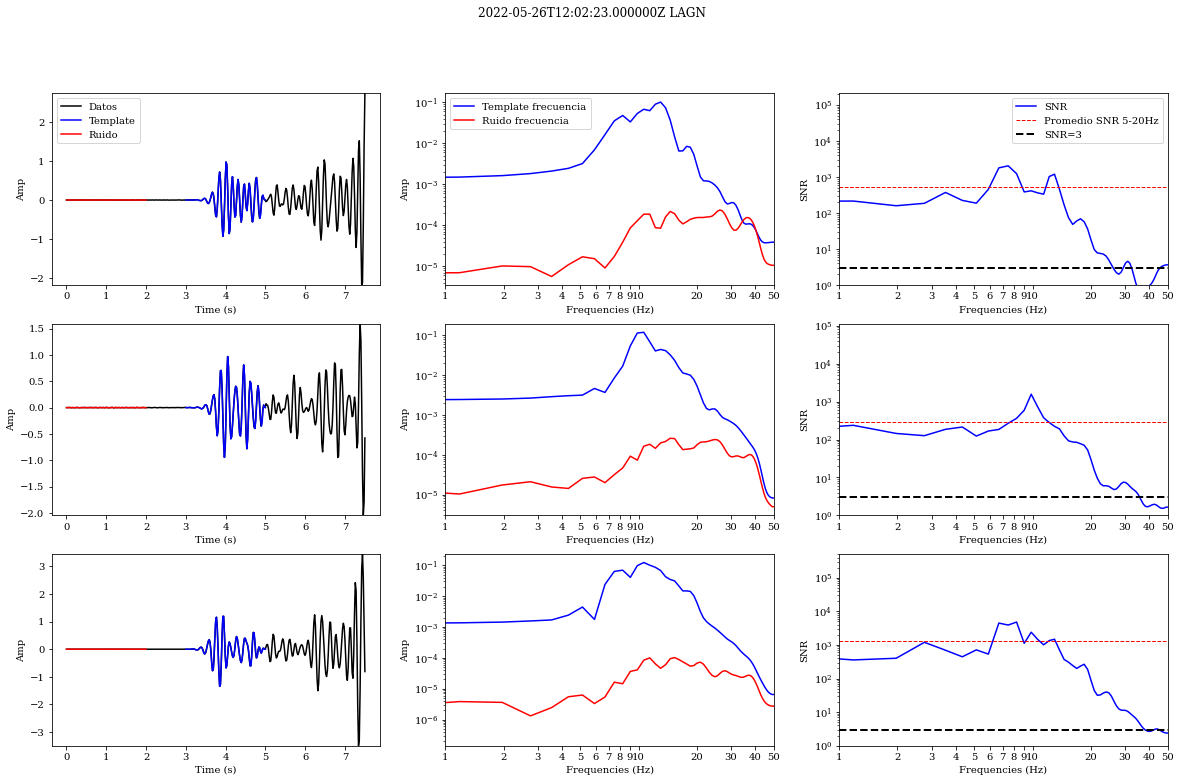

In [6]:
# Limpiamos la carpeta que puede tener templates antiguos
os.system('rm datos/templates/*')

# Definimos con que evento sísmico del catálogo comenzaremos y terminaremos para construir nuestros templates
begin_id = 0
end_id = 1

# Definimos listas para guardar un control de la calidad de los datos por estación y componente
good_chanels = []
good_stations = []
chanels = []
# Ciclo "for" sobre cada evento sísmico
jj = 0
for iii in np.arange(begin_id, end_id, 1):
    i = iii
    # Definimos el nombre del archivo con los arribos P y S para cada evento sísmico ocupado
    file_name_picks = 'info_'+mag_type[iii]+'_'+magnitude[iii]+'-'+orig_time[iii][0:19]+'.txt'
    print('Trabajando con el evento de: ', orig_time[iii])
    print('Tiempos de arribo P y S leídos de: ', file_name_picks)
    chanels.append([])
    # Lectura del archivo con los arrivos de onda P y S por cada evento sísmico
    with open(file_name_picks) as f:
        file_lines = f.read().splitlines()
        # Lectura de las estaciones con información de arrivo P y/o S
        station_read = []
        for j in np.arange(5,len(file_lines)-1,1):
            station_read.append(file_lines[j].split('.')[1])
        # Lectura y registro de los tiempos de arrivo P y S
        list_phases = []
        k = 0
        # Si hay información de arribos P y S, entonces len)file_files) > 5
        # y si se trabaja con ese archivo, sino, no se hace nada con ese evento
        if (len(file_lines) > 5):
            # Definición del archivo de datos sísmicos que contiene al evento a utilizar
            file_waves = path_to_data + 'waveforms_'+file_lines[5].split(';')[1][0:10]+'.hdf5'
            print('Se utilizará el archivo: ', file_waves)
            # ============= Lectura del archivo de datos sísmicos ==========================#
            # Si el archivo de datos sísmicos no esta abierto jj = 0
            if ( jj == 0 ):
                start_date = udt(file_lines[5].split(';')[1][0:11]+'00:00:00.00000Z')
                data = utils.load_data(file_waves)
                jj = 1
            # Si el archivo de datos ya fue abierto jj != 0
            else:
                if ( start_date == udt(file_lines[5].split(';')[1][0:11]+'00:00:00.00000Z')):
                    start_date = start_date
                else:
                    start_date = udt(file_lines[5].split(';')[1][0:11]+'00:00:00.00000Z')
                    data = utils.load_data(file_waves)
            # Lectura de la información de arribos P y S 
            for dup in sorted(list_no_duplicates(station_read)):
                list_temp = list(dup)
                if len(list_temp[1]) == 1:
                    phase_av = [file_lines[5+list_temp[1][0]].split(';')[5][0]]
                elif len(list_temp[1]) == 2:
                    phase_av = [file_lines[5+list_temp[1][0]].split(';')[5][0], file_lines[5+list_temp[1][1]].split(';')[5][0]]
                print('Fase disponible para estación ', dup, ': ', phase_av)
                list_temp.append(phase_av)
                # Estimar la muestra en tiempo de la fase P
                if 'P' in phase_av:
                    ind_P = phase_av.index('P')
                    # MODIFICAR SI SE TIENEN ARRIBOS DE ONDA S
                    #                                                 |                                                     |
                    list_temp.append([udt(file_lines[5+list_temp[1][ind_P]].split(';')[1]), udt(file_lines[5+list_temp[1][ind_P]].split(';')[1])])
                    samples = [int((list_temp[-1][0] - start_date) / sampling_rate), int((list_temp[-1][1] - start_date) / sampling_rate)]
                    list_temp.append(samples)
                    list_phases.append(list_temp)
                    k = k+1
            data_stations = []
            for ii in range(len(data['metadata']['stations'])):
                data_stations.append(data['metadata']['stations'][ii].split(".")[0])
            data_stationsfull = []
            for kk in range(len(list_phases)):
                if list_phases[kk][0] in data_stations:
                    index_station = data_stations.index(list_phases[kk][0])
                    data_stationsfull.append(data['metadata']['stations'][index_station].split(".")[0]+'.'+list_phases[kk][0])
        
        # Impresión de la información leido, tiempos de arribo        
        for phase in list_phases:
            print('Fase: ', phase)
        
        
        # Si hay información de arribos P y S, entonces len(list_phases) > 0
        if len(list_phases) > 0:
            # Definimos los tiempos de arribo P y S y los timepos de viaje P y S
            # tiempos de arribo = fecha de arribo P y S
            # tiempos de viaje = fecha de arribo - tiempo de origen del evento
            picks_P = []     #fechas P
            picks_S = []     #Fechas S
            tt_P = []        #tiempo viaje P
            tt_S = []        #tiempo viaje S
            count_s_i = []
            ki = 0
            origin_time = udt(orig_time[iii])
            # Extracción de las fechas de arribo P y S, y cálculo de los tiempos de viaje
            for s in range(len(list_phases)):
                if list_phases[s][0] in data_stations:
                    picks_P.append(list_phases[s][-2][1])
                    picks_S.append(list_phases[s][-2][0])
                    tt_P.append(list_phases[s][3][1]-udt(orig_time[iii]))
                    tt_S.append(list_phases[s][3][0]-udt(orig_time[iii]))
                    list_count = [s, ki]
                    count_s_i.append(list_count)
                    ki += 1
            # EN ESTE EJEMPLO PICKS P Y PICKS S SON IGUALES
            
            #================================================================#
            #       CONSTRUCCIÓN DE TEMPLATES                                #
            #================================================================#
            
            # Elejir cuantos segundos se quieren de señal antes del arribo de onda P
            # lo mismo para la onda S
            seconds_before = 0.2
            P_wave_buffer = np.int32( seconds_before / sampling_rate )
            S_wave_buffer = np.int32( seconds_before / sampling_rate )

            # Estimamos la muestra en tiempo de donde comenzará nuestra ventana
            # de información de ondas P y S
            picks_P_samples = []
            picks_S_samples = []
            beginning_P_windows = []
            beginning_S_windows = []
            for s in range(len(picks_P)):
                picks_P_samples.append(np.int32((picks_P[s]-start_date)/sampling_rate))
                picks_S_samples.append(np.int32((picks_S[s]-start_date)/sampling_rate))
                beginning_P_windows.append(picks_P_samples[s] - P_wave_buffer)
                beginning_S_windows.append(picks_S_samples[s] - S_wave_buffer)

            # Definimos cuantas estaciones, componentes y duración tendrá nuestro template
            n_stations = len(picks_P)
            n_components = 3
            
            # Duración en tiempo del template a usar
            duration = 2.0     # segundos
            duration = np.int32( duration / sampling_rate )
            # Arreglo que guardará las formas de onda
            template_waveforms = np.zeros((n_stations, n_components, duration), dtype=np.float32)

            # Definimos arreglos que se usar'an para calificar la calidad de los datos
            # se realizará un analisis señal/ruido en el dominio de la frecuencia
            # datos
            data_waveforms = np.zeros((n_stations, n_components, duration), dtype=np.float64)
            # ruido
            noise_waveforms = np.zeros((n_stations, n_components, duration), dtype=np.float64)
            npow2 = next_power_of_2(int(duration))
            padz = np.zeros((14), dtype=np.float64)
            # datos en frecuencia
            signal_spectra = np.zeros((n_stations, n_components, npow2), dtype=np.float64)
            # ruido en frecuencia
            noise_spectra = np.zeros((n_stations, n_components, npow2), dtype=np.float64)
            # datos/ruido
            snr = np.zeros((n_stations, n_components, npow2), dtype=np.float64)
            # datos/ruido en promedio
            mean_snr = np.zeros((n_stations, n_components), dtype=np.float64)

            # Definimos cuantos segundos antes de P tomaremos la ventana de ruido
            seconds_before_P = 3.0       # en segundos
            noise_samp_before = np.int32( seconds_before_P / sampling_rate )

            # Ciclo sobre las estaciones
            for p in range(len(count_s_i)):
                jj = data_stations.index(list_phases[count_s_i[p][0]][0])
                # Ciclo sobre las componentes
                for c in range(n_components):
                    # Si componentes horizontales EW y NS
                    if c < 2:
                        # Los datos se organizan de forma que c=0 E-W, c=1 N-S y c=2 vertical 
                        # inicio y fin de la ventana de datos
                        idx_start = beginning_S_windows[count_s_i[p][1]]
                        idx_end = idx_start + duration
                        # inicio y fin de la ventana de ruido
                        idx_start_noise = beginning_S_windows[count_s_i[p][1]] - noise_samp_before
                        idx_end_noise = idx_start_noise + duration
                    # Si componentes horizontales
                    # EN ESTE CASO TOMAREMOS LA ONDA P EN VEZ DE LA S
                    else:
                        # inicio y fin de la ventana de datos
                        idx_start = beginning_P_windows[count_s_i[p][1]] 
                        idx_end = idx_start + duration
                        # inicio y fin de la ventana de ruido
                        idx_start_noise = beginning_P_windows[count_s_i[p][1]] - noise_samp_before
                        idx_end_noise = idx_start_noise + duration

                    # Se realiza el corte de los datos de onda P, S y ruido

                    # Datos para el template
                    template_waveforms[p, c, :] = data['waveforms'][jj][c][idx_start:idx_end]

                    # Datos para analisis señal/ruido
                    # SEÑAL
                    tr_signal = obs.Trace(data['waveforms'][jj][c][idx_start:idx_end])
                    tr_signal.taper(0.05, type='hann', max_length=None, side='both')
                    data_waveforms[p, c, :] = tr_signal
                    # RUIDO
                    tr_noise = obs.Trace(data['waveforms'][jj][c][idx_start_noise:idx_end_noise])
                    tr_noise.taper(0.05, type='hann', max_length=None, side='both')
                    noise_waveforms[p, c, :] = tr_noise

            # Variables ocupadas para control de calidad (si pasan el test señal/ruido)
            count_good_chanels = 0
            count_good_stations = 0
            sta_chan = []
            # Ciclo sobre las estaciones
            for p in range(len(count_s_i)):
                jj = data_stations.index(list_phases[count_s_i[p][0]][0])
                list_chan = [data_stations[jj]]
                # En caso de querer graficar alguna estación jj = estación a graficar
                if jj == station_plot:
                    # Variables para construir gráficas
                    figsize = (20, 12)
                    fig_n = plt.figure(11, figsize=figsize)
                    time1 = np.linspace(0., duration*sampling_rate, duration)
                    # Vector tiempo grande para mostrar los datos alrededor
                    time_large_window = duration*3.75
                    time2 = np.linspace(0., time_large_window*sampling_rate, int(time_large_window))
                for c in range(n_components):
                    if jj == station_plot:
                        # Graficamos los datos, el template y el ruido
                        ax_n = fig_n.add_subplot(3,3,(c*3)+1)
                        ax_n.plot(time2, data['waveforms'][jj][c][beginning_P_windows[count_s_i[p][1]]-150:beginning_P_windows[count_s_i[p][1]]+225], color='k', label='Datos')
                        ax_n.plot(time1+3., data_waveforms[p, c, :], color='b', label='Template')
                        ax_n.plot(time1+0, noise_waveforms[p, c, :], color='red', label='Ruido')
                        ax_n.set_xlabel('Time (s)')
                        ax_n.set_ylabel('Amp')
                        maxy = np.max(data['waveforms'][jj][c][beginning_P_windows[count_s_i[p][1]]-150:beginning_P_windows[count_s_i[p][1]]+225])
                        miny = np.min(data['waveforms'][jj][c][beginning_P_windows[count_s_i[p][1]]-150:beginning_P_windows[count_s_i[p][1]]+225])
                        ax_n.set_ylim([miny,maxy])
                        # Agrega la leyenda al gráfico
                        if c == 0:
                            ax_n.legend()

                    #======================================================================#
                    #         Realizamos el análisis SEÑAL/RUIDO                           #
                    #======================================================================#
                    frequences = np.linspace(- 1/(2./100), 1/(2/100), npow2)

                    # Calculamos el espectro de amplitud del ruido
                    noise = np.hstack((padz, noise_waveforms[p, c, :], padz))
                    # fft del ruido
                    fft_noise = np.fft.fft(noise, npow2)
                    # espectro de amplitudes
                    fft_abs_noise = np.abs(np.fft.fftshift(fft_noise)) / npow2
                    # suavizamos el espectro
                    noise_smooth = ko.faster_konno_ohmachi(fft_abs_noise, frequences, n_cores=None)
                    # guardamos el espectro
                    noise_spectra[p, c, :] = noise_smooth

                    # Cálculo del espectro de la señal P o S
                    signal = np.hstack((padz, data_waveforms[p, c, :], padz))
                    # fft de la señal
                    fft_signal = np.fft.fft(signal, npow2)
                    # espectro de amplitud de la señal
                    fft_abs_signal = np.abs(np.fft.fftshift(fft_signal)) / npow2
                    # suavizamos el espectro
                    signal_smooth = ko.faster_konno_ohmachi(fft_abs_signal, frequences, n_cores=None)
                    # guardamos el espectro
                    signal_spectra[p, c, :] = signal_smooth
                    
                    # Cálculo de la razon SEÑAL / RUIDO
                    snr[p, c, :] = [x/y for x, y in zip(signal_smooth, noise_smooth)]
                    # Promedio de la razon SEÑAL/RUIDO en cierta banda de frecuencias
                    mean_snr[p, c] = np.mean(snr[p, c, 70:90])
                    
                    # TEST DE CONTROL DE CALIDAD
                    
                    # Verificamos si SNR > water_level
                    water_level = 3.
                    if mean_snr[p, c] > water_level:
                        count_good_chanels += 1
                        list_chan.append(c)

                    # Graficamos los espectros de la señal y el ruido
                    if jj == station_plot:
                        ax_n = fig_n.add_subplot(3,3,(c*3)+2)
                        ax_n.loglog(frequences[32:], signal_spectra[p,c,32:], color='b', label='Template frecuencia')
                        ax_n.loglog(frequences[32:], noise_spectra[p,c,32:], color='r', label='Ruido frecuencia')
                        ax_n.set_xlabel('Frequencies (Hz)')
                        ax_n.set_ylabel('Amp')
                        if c == 0:
                            ax_n.legend()
                        ax_n.set_xlim([1, 50])
                        ax_n.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50])
                        ax_n.set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50])

                        # Graficamos la razon SEÑAL/RUIDO SNR
                        ax_n = fig_n.add_subplot(3,3,(c*3)+3)
                        ax_n.loglog(frequences[32:], snr[p, c, 32:], color='b', label='SNR')
                        ax_n.axhline(mean_snr[p,c], lw=1, ls='--', color='r', label='Promedio SNR 5-20Hz')
                        ax_n.axhline(water_level, lw=2, ls='--', color='k', label='SNR=3')
                        ax_n.set_xlabel('Frequencies (Hz)')
                        ax_n.set_ylabel('SNR')
                        ax_n.set_ylim([1, mean_snr[p,c]*400])
                        if c == 0:
                            ax_n.legend()
                        ax_n.set_xlim([1, 50])
                        ax_n.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50])
                        ax_n.set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50])

                # Guardamos registro de los canales que pasan el test de calidad
                if len(list_chan) > 1:
                    count_good_stations += 1
                chanels[-1].append(list_chan)

                # Titulo para la figura y guardamos la figura
                if jj == station_plot:
                    fig_n.suptitle(orig_time[iii]+' '+data_stations[jj])
                    fig_n.show()
                    fig_n.savefig('snr_event_'+str(iii)+'_'+data_stations[jj]+'.eps')

            good_chanels.append(count_good_chanels)
            good_stations.append(count_good_stations)

            # Guardamos toda la información asociada a nuestro template
            beginning_P_windows = np.array(beginning_P_windows)
            beginning_S_windows = np.array(beginning_S_windows)
            reference_time = min(beginning_P_windows.min(), beginning_S_windows.min())
            moveouts_P = beginning_P_windows - reference_time
            moveouts_S = beginning_S_windows - reference_time

            # Desface entre ondas P y S
            moveouts = np.hstack( (moveouts_S.reshape(-1, 1), # first horizontal component
                           moveouts_S.reshape(-1, 1), # second horizontal component
                           moveouts_P.reshape(-1, 1)) ) # vertical component

            # Escribimos el archivo con toda la información
            file_template = path_template + catalog_lines[i+1].split(";")[1][:-1] + ".hdf5"
            with h5.File(file_template, mode='w') as f:
                depth_i = [ float(depth[i]) ]
                lat_i = [ float(latitude[i]) ]
                lon_i = [ float(longitude[i]) ]
                mag_i = [ float(magnitude[i]) ]
                orig_i = udt(orig_time[i]).timestamp
                f.create_dataset('depth', data=np.array(depth_i, dtype='float32'))
                f.create_dataset('latitude', data=np.array(lat_i, dtype='float32'))
                f.create_dataset('longitude', data=np.array(lon_i, dtype='float32'))
                f.create_dataset('magnitude', data=np.array(mag_i, dtype='float32'))
                f.create_dataset('origin_time', data=np.asarray(orig_i))
                f.create_dataset('stations', data=np.array((data_stationsfull), dtype='|S8'))
                f.create_dataset('p_travel_times', data=tt_P, dtype='float32')
                f.create_dataset('s_travel_times', data=tt_S, dtype='float32')
                f.create_dataset('moveouts_P', data=moveouts_P, dtype='float32')
                f.create_dataset('moveouts_S', data=moveouts_S, dtype='float32')
                f.create_dataset('sampling_rate', data=sampling_freq, dtype='float64')
                f.create_dataset('waveforms', data=np.array(template_waveforms, dtype='float64'))
                print('Base de datos del template ha sido guardada:\n', list(f.keys()))
                f.close()

# Opcional: Revisión de control de calidad

In [7]:
# Revisamos que estaciones y canales tiene una buena señal ruido después de nuestro análisis
chanels_dic = {}
for i in range(len(chanels)):
    names = []
    goods = []
    for k in range(len(chanels[i])):
        if len(chanels[i][k]) == 1:
            chanels_dic[chanels[i][k][0]+'_'+str(i).zfill(4)] = []
        else :
            goods.append([0, 0, 0])
            names.append(chanels[i][k][0])
            for j in range(3):
                if j in chanels[i][k][1:]:
                    goods[-1][j] = 1
            chanels_dic[chanels[i][k][0]+'_'+str(i).zfill(4)] = chanels[i][k][1:]
            file_good_chanels = 'good_chanels_t_' +str(orig_time[i+begin_id])[0:-5]+ ".hdf5"
            with h5.File(file_good_chanels, mode='w') as f:
                f.create_dataset('names', data=np.array((names), dtype='|S8'))
                f.create_dataset('goods', data=np.array((goods), dtype='float32'))
                f.close()


In [8]:
print(names,goods)

['LAGN'] [[1, 1, 1]]
